In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.4 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.


In [38]:

import os
import cv2
import random
import pathlib
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from typing import Tuple, Dict, List

import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import Dataset

import albumentations
from albumentations.pytorch.transforms import ToTensor, ToTensorV2

from PIL import Image, ImageFile, ImageFont, ImageDraw, ImageEnhance
ImageFile.LOAD_TRUNCATED_IMAGES = True

import warnings
warnings.filterwarnings('ignore')

FUSED_SHAPE = (640, 480)
ORIGINAL_SHAPE = (4000, 3000)

In [6]:
from datasets import load_dataset

dataset = load_dataset("mllab/alfafood")


Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/3346 [00:00<?, ? examples/s]

# EDA

In [7]:
len(dataset['train']) # all data in train

3346

In [8]:
original_shape = dataset['train'][0]['image'].size
original_shape

(4000, 3000)

In [9]:
dataset['train'][4]

{'image': <PIL.Image.Image image mode=RGB size=4000x3000>,
 'objects': {'bbox': [[1398.17, 354.76, 486.59, 365.85],
   [406.71, 18.17, 2513.41, 1532.93],
   [1328.66, 680.37, 610.97, 197.56]],
  'categories': [9, 99, 11]}}

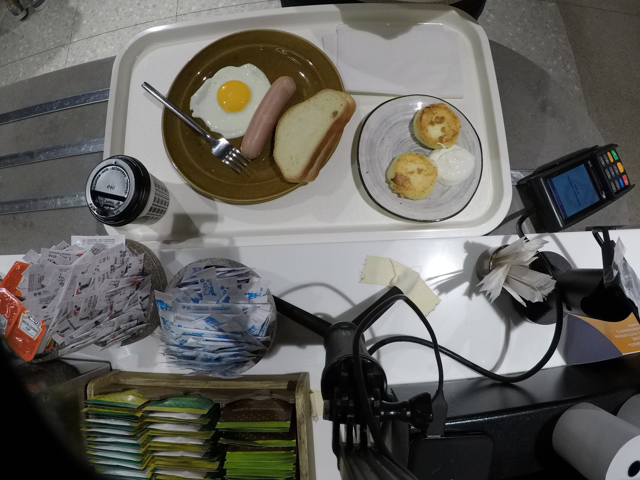

In [10]:
dataset['train'][5]['image'].resize(FUSED_SHAPE)

# NB! Delete after ended

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
id2cat_path = '/content/drive/MyDrive/datasets/alfafood/'

In [86]:
def fused_bbox(bboxes, original_shape, fused_shape):

    x_fused = fused_shape[0] / original_shape[0]
    y_fused = fused_shape[1] / original_shape[1]

    for i in range(len(bboxes)):
        bboxes[i][0] = bboxes[i][0] * x_fused
        bboxes[i][1] = bboxes[i][1] * y_fused
        bboxes[i][2] = bboxes[i][2] * x_fused
        bboxes[i][3] = bboxes[i][3] * y_fused

    # print(bboxes)

    return bboxes

In [11]:
bbox_transform = albumentations.Compose(
    [albumentations.Resize(height=FUSED_SHAPE[1], width=FUSED_SHAPE[0]),
     albumentations.HorizontalFlip(p=0.6),
     albumentations.Rotate(p=1),
     albumentations.pytorch.transforms.ToTensorV2()],
    bbox_params=albumentations.BboxParams(format='pascal_voc', label_fields=['labels'])
)

In [69]:
dataset['train'][10]['objects']['bbox']

[[662.8, 764.51, 471.96, 490.25],
 [4.27, 120.61, 1452.44, 1470.73],
 [0.61, 742.56, 182.93, 508.54],
 [358.2, 405.98, 374.8, 439.82],
 [40.85, 965.73, 512.2, 413.42]]

In [87]:
images = [dataset['train'][i]['image'].resize(FUSED_SHAPE) for i in range(10)]
objects = [dataset['train'][i]['objects'] for i in range(10)]

for i in range(10):
    if objects[i]['bbox'] != []:
        objects[i]['bbox'] = fused_bbox(objects[i]['bbox'], ORIGINAL_SHAPE, FUSED_SHAPE)


class AlfaFoodDataset(Dataset):

    def __init__(self, images, objects, transform=None):
        self.images = images
        self.objects = objects
        self.transform = transform


    def __getitem__(self, index: int) -> Tuple[torch.Tensor, Tuple[Tuple[int]], Tuple[int]]:
        "Returns one sample of data: image, labels, bboxes"

        image = np.array(self.images[index].convert('RGB'))#.transpose(1, 2, 0)
        bboxes = self.objects[index]['bbox']
        labels = self.objects[index]['categories']

        if self.transform:
            for bbox in bboxes:
                bbox[2] += bbox[0]
                bbox[3] += bbox[1]

            # print(bboxes)
            transformed = self.transform(image = image, bboxes = bboxes, labels = labels)
            image = np.array(transformed['image']).transpose(1, 2, 0)
            bboxes = transformed['bboxes']
            labels = transformed['labels']

        return image, bboxes, labels


    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.images)

data = AlfaFoodDataset(images, objects, transform = bbox_transform)

img, bboxes, labels = data[7]

# print(labels)


[{'bbox': [], 'categories': []}, {'bbox': [[1185.98, 460.85, 651.22, 841.47], [618.9, 3.54, 2571.95, 1562.19], [1661.59, 358.42, 515.85, 896.34]], 'categories': [1, 99, 2]}, {'bbox': [[1325.0, 303.54, 845.12, 735.36], [1767.68, 435.24, 515.86, 457.32], [150.61, 21.83, 2367.07, 1543.9], [1325.0, 691.34, 819.51, 790.25]], 'categories': [3, 5, 99, 4]}, {'bbox': [[505.49, 21.83, 2560.97, 1540.24], [1346.95, 116.95, 607.32, 687.81], [1573.78, 0.0, 696.22, 892.56], [2766.46, 1064.51, 267.08, 292.68], [1365.24, 695.0, 537.81, 270.73], [1317.68, 523.05, 453.66, 314.63], [596.95, 808.42, 453.66, 504.87], [2020.12, 746.22, 493.9, 537.8]], 'categories': [99, 6, 3, 7, 9, 9, 10, 8]}, {'bbox': [[1398.17, 354.76, 486.59, 365.85], [406.71, 18.17, 2513.41, 1532.93], [1328.66, 680.37, 610.97, 197.56]], 'categories': [9, 99, 11]}, {'bbox': [[2408.8, 636.46, 561.7, 610.14], [527.44, 969.39, 530.49, 446.34], [1185.98, 384.02, 515.85, 486.59], [1500.61, 471.83, 354.88, 519.51], [1701.83, 548.66, 486.59, 610

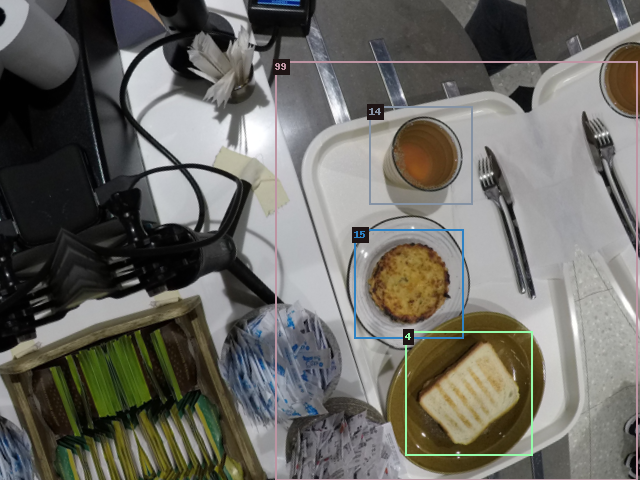

In [90]:
# img, bboxes, labels = data[4]
def show_image_with_objects(image, bboxes, labels=None):

    img = Image.fromarray(image)

    color = list((random.randint(40, 240), random.randint(40, 255), random.randint(60, 255)) for i in range(100))

    random.shuffle(color)

    for i in range(len(bboxes)):
        draw = ImageDraw.Draw(img)
        draw.rectangle(bboxes[i], outline = color[i], width=2)

        bbox = draw.textbbox((bboxes[i][0], bboxes[i][1]), f"{labels[i]}")
        draw.rectangle((bbox[0]-2, bbox[1]-2, bbox[2]+2, bbox[3]+2), fill=(30, 20, 20))
        draw.text((bboxes[i][0], bboxes[i][1]), f"{labels[i]}", color[i])
    return img

show_image_with_objects(img, bboxes, labels)


In [ ]:
import json

with open("id2cat.json") as json_file:
    json_data = json.load(json_file)
print(json_data)

{'1': 'Поднос', '2': 'Вода Cafetera 0,33л', '3': 'Яичница глазунья 1яйцо', '4': 'Хашбрауны 2шт/100гр', '5': 'В стакане Киви 200гр', '6': 'Какао 200гр', '7': 'Запеканка творожная/вишня 100/20гр', '8': 'Каша из гречневых хлопьев/пост 250гр', '9': 'Сырники со сметаной 100/20гр', '10': 'Напиток из ягод с/м/без сахара 200гр', '11': 'Омлет с ветчиной 130гр', '12': 'Сарделька отварная/жареная 1шт/140гр', '13': 'В стакане Абрикос/без косточек 200гр', '14': 'В стакане Клубника 100гр', '15': 'Каша Дружба/молоко 250гр', '16': 'Булочка французская в асс 1шт', '17': 'Кофе Американо фильтр/молотый 400гр', '18': 'Кофе Американо фильтр/молотый 250гр', '19': 'Баунти/Марс/Сникерс', '20': 'Напиток Яблоневый сад 200гр', '21': 'Нагетс куриный 1шт', '22': 'Ланч бокс в асс 1шт', '23': 'Грилата в асс 1шт', '24': 'Яйцо вареное 1шт', '25': 'Омлет на тосте/с.грибной 1шт/130гр', '26': 'Ряженка 500мл МК', '27': 'Сосиска Сливочная отварная/жаре 1шт/65гр', '28': 'С-т из б/к/редис 120гр', '29': 'Горячий Бутерброд с к

In [ ]:
# Исходная строка
unicode_string = "\u041f\u043e\u0434\u043d\u043e\u0441"

# Раскодирование строки
decoded_string = unicode_string.encode().decode('utf-8')

# Вывод результата
print(decoded_string)


Поднос
